<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/mask_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model training on Mask 2017 dataset

The following models will be trained:

| Model | Backbone | Image Size | Parameters | GFLOPs
| --- | --- | --- | --- | --- |
| SSDlite320 | MobileNetV3-Large | 320x320 | 3.4M | 1.2 |
| SSD300 | VGG16 | 300x300 | 35.6M | 69.8 |
| Faster R-CNN |  MobileNetV3-Large FPN | 800x800 | 19.4M | 9.1 |
| Faster R-CNN |  ResNet-50 FPN | 800x800 | 41.8M | 269.1 |
| Mask R-CNN |  ResNet-50 FPN | 800x800 | 44.4M | 269.1 |
| YOLOv5s |  Custom | 640x640 | 7.3M | 17 |
| YOLOv5m |  Custom | 640x640 | 21.4M | 51.3 |
| YOLOv5l |  Custom |640x640 | 47M | 115.5 |
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 |
| YOLOv3 |  Darknet53 | 640x640 | 61.9M | 156.3 |
| YOLOv3-spp |  Darknet53 | 640x640 | 63M | 157.1 |

The following hyperparameters for each model will be used:

| Model | Backbone | Batch Size | Epochs | Learning Rate | Optimizer | Momentum | Weight Decay |
| --- | --- | --- | --- | --- | --- | --- | --- |
| SSDlite320 | MobileNetV3-Large |  |  |  |
| SSD300 | VGG16 |  |  |  |
| Faster R-CNN |  MobileNetV3-Large FPN |  |  |  |
| Faster R-CNN |  ResNet-50 FPN |  |  |  |
| Mask R-CNN |  ResNet-50 FPN |  |  |  |
| YOLOv5s |  Custom |  |  |  |
| YOLOv5m |  Custom |  |  |  |
| YOLOv5l |  Custom | |  |  |
| YOLOv3-tiny |  Darknet53 |  |  |  |
| YOLOv3 |  Darknet53 |  |  |  |
| YOLOv3-spp |  Darknet53 |  |  |  |

<br>

**Note: GPU Runtime needed**

*Example GPU: Tesla K80, 460.32.03, 11441 MiB*




In [2]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


### Training Parameters

In [1]:
# Training Parameters

num_workers = 2  #  Data loader workers
batch_size = 8  # Data loader batch size (both training and inference)

num_epochs = 50  # Epochs

lr = 0.01  # Learning rate
step_size = 3  # Learning rate step size
gamma = 0.1  # Learning rate decay

optimizer_type = 'sgd'
momentum = 0.937  # Optimizer momentum (only for SGD optimizer)
weight_decay = 0.0005  # Optimizer weight decay

load_ckpt = False # Flag for whether to load existing checkpoint or not
load_ckpt_file = 'mask_ssd300_vgg16_bs16_adam_lr0.005_ss3_g0.1_m0.9_wd0.0005_timestamp1630075282_epoch1'

### Get requirements
*Note: Restart runtime after installation*

In [3]:
%%shell

# Install Yolov5
cd /content
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install --quiet -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 9194, done.
remote: Total 9194 (delta 0), reused 0 (delta 0), pack-reused 9194
Receiving objects: 100% (9194/9194), 9.66 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (6379/6379), done.
     |████████████████████████████████| 3.0 MB 5.2 MB/s 
     |████████████████████████████████| 636 kB 40.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
%%shell

# Install Yolov3
cd /content
git clone https://github.com/ultralytics/yolov3
cd yolov3
pip install --quiet -r requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 9862, done.
remote: Total 9862 (delta 0), reused 0 (delta 0), pack-reused 9862
Receiving objects: 100% (9862/9862), 9.19 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (6666/6666), done.


In [5]:
%%shell

# Install flops-counter
pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.6-py3-none-any.whl size=8903 sha256=bd4a2ac7de02316fccfdad27abbc9db27245aef6819d1d05531cf53383a0c062
  Stored in directory: /root/.cache/pip/wheels/eb/7c/e5/2332373fcac1b39ba9eb95698ac370da3e14eaba5516e22721
Successfully built ptflops


In [6]:
%%shell

# Clone asset files
cd /content
git clone https://github.com/joangog/object-detection-assets
cd object-detection-assets
mv scripts ../
mv config ../
rm -rf /content/object-detection-assets/

Cloning into 'object-detection-assets'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 47 (delta 9), reused 41 (delta 6), pack-reused 0
Unpacking objects: 100% (47/47), done.


### Import packages

In [3]:
# Import packages

from google.colab import files
from google.colab import drive

import os, sys
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import math
import time
import copy
import re

import numpy as np
import pandas as pd
import json
import PIL
import IPython

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from pycocotools import coco
from pycocotools import mask as cocomask

from ptflops import get_model_complexity_info

import scripts.utils as SU
import scripts.transforms as ST
import scripts.coco_utils as SCU
from scripts.coco_eval import CocoEvaluator

### Define auxiliary functions

In [4]:
def convert_to_xyxy(bboxes):  # formats bboxes from (x,y,w,h) to (x,y,x,y)
  for bbox in bboxes:
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]
  return bboxes

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = SU.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SU.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = SU.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):

        images = list(image.to(device) for image in images)
        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLOv5 package
          images = [F.to_pil_image(image) for image in images]  # Convert images from tensor to PIL

        # Format targets for torchvision models
        formatted_targets = []
        for i, img_targets in enumerate(targets):
          # Stack boxes, masks (optionally) and labels of image targets into tensor
          boxes = torch.stack([torch.squeeze(torch.Tensor(convert_to_xyxy([target['bbox']])),0) for target in img_targets]).long()
          labels = torch.Tensor([target['category_id'] for target in img_targets]).long()
          if model.__class__.__name__ == 'MaskRCNN':  # Get masks only for segmentation models
            masks = []
            # Convert every mask from polygon to binary mask
            for target in img_targets:
              for mask in target['segmentation']:
                height = images[i].shape[1]
                width = images[i].shape[2]
                formatted_mask = torch.Tensor(cocomask.decode(cocomask.frPyObjects([mask], height, width)))
                masks.append(formatted_mask)
            masks = torch.stack(masks).long()
            formatted_targets.append({'boxes': boxes, 'masks': masks, 'labels': labels})
          else:
            formatted_targets.append({'boxes': boxes, 'labels': labels})

        formatted_targets = [{k: v.to(device) for k, v in t.items()} for t in formatted_targets]

        loss_dict = model(images, formatted_targets)

        losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced = SU.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, M.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, M.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = SU.MetricLogger(delimiter="  ")
    header = 'Test:'
    coco = SCU.get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    # Get label names
    label_ids = data_loader.dataset.coco.getCatIds()
    label_info = data_loader.dataset.coco.loadCats(label_ids)
    label_names = [label['name'] for label in label_info]
    labels = dict(zip(label_ids, label_names))  # Label dictionary with id-name as key-value
    labels_inv = dict(zip(label_names, label_ids))  # Inverse label dictionary with name-id as key-value

    for images, targets in metric_logger.log_every(data_loader, 100, header):

        images = list(img.to(device) for img in images)
        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLO package
            images = [F.to_pil_image(image) for image in images]  # Convert images from tensor to PIL

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        model_time = time.time()
        outputs = model(images)  # Get model predictions
        model_time = time.time() - model_time

        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLO package
            # Format outputs to COCO format
            outputs_formatted = []
            for img_outputs in outputs.xyxy:
                output_bboxes = img_outputs[:, :4]
                output_scores = img_outputs[:, 4]
                output_labels = img_outputs[:, 5].to(cpu_device).apply_(
                    lambda x: labels_inv[label_names[int(x)]])  # Convert YOLO label ids to COCO label ids
                outputs_formatted.append({
                    'boxes': output_bboxes,
                    'scores': output_scores,
                    'labels': output_labels
                })
            outputs = outputs_formatted

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        # test lines #######################

        # label_ids = dataset.coco.getCatIds()
        # label_info = dataset.coco.loadCats(label_ids)
        # label_names = [label['name'] for label in label_info]
        # labels = dict(zip(label_ids,label_names))

        # img = F.convert_image_dtype(images[1],torch.uint8).cpu()

        # true_bboxes = F.Tensor([obj['bbox'] for obj in targets[1]]).cpu()
        # true_labels = [labels[obj['category_id']] for obj in targets[1]]
        # true_img = U.draw_bounding_boxes(img, true_bboxes, true_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(true_img))

        # output = outputs[1]
        # pred_bboxes = torch.stack([output['boxes'][i] for i in range(0,len(output['boxes'])) if output['scores'][i] > th])
        # pred_labels_ids = output['labels'].tolist()
        # pred_label_ids = [pred_labels_ids[i] for i in range(0,len(pred_labels_ids)) if output['scores'][i] > th]
        # pred_labels = [labels[label_id] for label_id in pred_label_ids]
        # pred_img = U.draw_bounding_boxes(img, pred_bboxes, pred_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(pred_img))

        # fig()

        ###############

        res = {target[0]["image_id"]: output for target, output in zip(targets, outputs) if len(target) != 0}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)

    # Model FPS
    batch_size = data_loader.batch_size
    fps = batch_size / metric_logger.meters['model_time'].global_avg

    # Model maximum memory usage
    MB = 1024.0 * 1024.0
    max_mem = torch.cuda.max_memory_allocated() / MB  # in MegaBytes

    return coco_evaluator, fps, max_mem, outputs

### Download Mask dataset

In [5]:
%%shell

cd /content
mkdir -p dataset
cd dataset
mkdir -p images annotations labels
cd labels
mkdir val_images train_images test_images


In [6]:
%%shell

cd /content/dataset/images

# Download validation images
gdown --id '101F2k6PJ-tD_uwlsCG7zzGF9ILJW01M1'
unzip -q -n 'val_images.zip'

# Download train images
gdown --id '1vD_Sxg7dHkB_8OJLsHngBWvp5iGJAETQ'
unzip -q -n 'train_images.zip'

# Download test images
gdown --id '1SXmddH448m3SYgyWBeRbFruOeOMfECjZ'
unzip -q -n 'test_images.zip'

Downloading...
From: https://drive.google.com/uc?id=101F2k6PJ-tD_uwlsCG7zzGF9ILJW01M1
To: /content/dataset/images/val_images.zip
14.9MB [00:00, 45.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vD_Sxg7dHkB_8OJLsHngBWvp5iGJAETQ
To: /content/dataset/images/train_images.zip
83.6MB [00:01, 71.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SXmddH448m3SYgyWBeRbFruOeOMfECjZ
To: /content/dataset/images/test_images.zip
94.5MB [00:01, 91.2MB/s]


In [7]:
%%shell

cd /content/dataset/annotations

# Download validation annotations
gdown --id '1YLV7-7vmiNdFI8Xpdx_jbhnxfgQRWrgF'
cp '/content/dataset/annotations/val.json' '/content/dataset/images/val_images'

# Download train annotations
gdown --id '1AqeDJps-aZ743vFJ6p2_RjtSFjPtIOtD'
cp '/content/dataset/annotations/train.json' '/content/dataset/images/train_images'

# Download test annotations
gdown --id '10X-B2_tf8KI9EJy4mSi3YwFroI0CRKEl'
cp '/content/dataset/annotations/test.json' '/content/dataset/images/test_images'

Downloading...
From: https://drive.google.com/uc?id=1YLV7-7vmiNdFI8Xpdx_jbhnxfgQRWrgF
To: /content/dataset/annotations/val.json
100% 105k/105k [00:00<00:00, 39.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AqeDJps-aZ743vFJ6p2_RjtSFjPtIOtD
To: /content/dataset/annotations/train.json
100% 644k/644k [00:00<00:00, 42.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=10X-B2_tf8KI9EJy4mSi3YwFroI0CRKEl
To: /content/dataset/annotations/test.json
100% 83.3k/83.3k [00:00<00:00, 39.6MB/s]


### (Only for YOLO models) Convert format of annotations from COCO to YOLO

In [8]:
label_dir = '/content/dataset/labels'  # Yolo labels
ann_dir = '/content/dataset/annotations'  # COCO annotations

types = ['val', 'train']

for type in types:

    ann_path = os.path.join(ann_dir, type + ".json")
    dataset = coco.COCO(ann_path)
    img_ids = dataset.getImgIds()

    for img_id in img_ids:

      img_anns = dataset.loadAnns(dataset.getAnnIds([img_id]))
      img_data = dataset.loadImgs([img_id])[0]
      img_file = img_data['file_name']
      img_width = img_data['width']
      img_height = img_data['height']

      label_file = img_file.replace('.jpg','.txt')
      
      with open(os.path.join(label_dir, f'{type}_images', label_file), 'w') as outfile:
        for ann in img_anns:
          x_center = (ann['bbox'][0] + ann['bbox'][2]/2) / img_width  # convert x_min to x_center and normalize to [0,1]
          y_center = (ann['bbox'][1] + ann['bbox'][3]/2) / img_height  # convert y_min to y_center and normalize to [0,1]
          width = ann['bbox'][2] / img_width
          height = ann['bbox'][3] / img_height 
          outfile.write("{} {} {} {} {}\n".format(ann['category_id'],x_center,y_center,width,height))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Load Mask dataset

In [5]:
val_img_dir = '/content/dataset/images/val_images'
val_ann_file = 'val.json'  # annotations
val_ann_path = os.path.join(val_img_dir,val_ann_file)  

train_img_dir = '/content/dataset/images/train_images'
train_ann_file = 'train.json'  # annotations
train_ann_path = os.path.join(train_img_dir,train_ann_file)  

test_img_dir = '/content/dataset/images/test_images'
test_ann_file = 'test.json'  # annotations
test_ann_path = os.path.join(test_img_dir,test_ann_file)  

# Define data transforms
transforms = ST.Compose([ST.ToTensor()])

# Create datasets
val_dataset = CocoDetection(val_img_dir, val_ann_path, transforms = transforms)
train_dataset = CocoDetection(train_img_dir, train_ann_path, transforms = transforms)
test_dataset = CocoDetection(test_img_dir, test_ann_path, transforms = transforms)

# Create data loaders
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Load pre-trained model

In [6]:
%cd /content

# Delete utils package to reload it (if loaded), because YOLOv3 and YOLOv5 have
# the same name for it and it causes error
try:
  sys.modules.pop('utils')
except:
  pass

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv5l' # @param ['SSD300 VGG16', 'SSDlite320 MobileNetV3-Large', 'Faster R-CNN ResNet-50 FPN', 'Faster R-CNN MobileNetV3-Large FPN', 'Mask R-CNN ResNet-50 FPN', 'YOLOv5s', 'YOLOv5m', 'YOLOv5l', 'YOLOv3', 'YOLOv3-tiny', 'YOLOv3-spp']

# @markdown *Note: If you get the error "Cache may be out of date, try 'force_reload=True'" then restart runtime.*

if model_name == 'SSD300 VGG16':
  model_id = 'ssd300_vgg16'
  model = M.ssd300_vgg16(pretrained=True, progress=True)
  model_img_size = (3,300,300)
elif model_name == 'SSDlite320 MobileNetV3-Large':
  model_id = 'ssdlite320_mobilenet_v3_large'
  model = M.ssdlite320_mobilenet_v3_large(pretrained=True, progress=True)
  model_img_size = (3,320,320)
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn_resnet50_fpn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) # COCO's 640x640 in upscaled to the model's minimum 800x800
elif model_name == 'Faster R-CNN MobileNetV3-Large FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) 
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn_resnet50_fpn'
  model = M.maskrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800)
elif model_name == 'YOLOv5s':
  model_id = 'yolov5s'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5m':
  model_id = 'yolov5m'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5m', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5l':
  model_id = 'yolov5l'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5l', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3':
  model_id = 'yolov3'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-tiny':
  model_id = 'yolov3_tiny'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_tiny', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-spp':
  model_id = 'yolov3_spp'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_spp', force_reload=True)
  model_img_size = (3,640,640)

print('-------------------------------------------------------------------------------------------------------\n')

print(f'Loaded model: {model_name}')
model_params = round(sum([param.numel() for param in model.parameters()]) / 1000000, 1)
print(f'\t- Parameters: {model_params}M')
model_macs, _ = get_model_complexity_info(model, model_img_size, as_strings=False, 
                                          print_per_layer_stat=False, verbose=False)
model_gflops = round(2 * int(model_macs) / 1000000000, 1)
print(f'\t- GFLOPs: {model_gflops}')

/content


Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


  0%|          | 0.00/755k [00:00<?, ?B/s]

YOLOv5 🚀 2021-9-6 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)



  0%|          | 0.00/90.2M [00:00<?, ?B/s]

Fusing layers... 
Model Summary: 392 layers, 47025981 parameters, 0 gradients
Adding AutoShape... 


-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv5l
	- Parameters: 47.0M
	- GFLOPs: 115.5


### Train model

In [7]:
# Mount GDrive to save model checkpoints
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Set checkpoint directory
ckpt_dir = '/content/drive/MyDrive/object-detection-checkpoints'

# Load pre-existing checkpoint weights if required
last_epoch = 0
if load_ckpt:
  load_ckpt_path = os.path.join(ckpt_dir,load_ckpt_file)
  model.load_state_dict(torch.load(load_ckpt_path))
  last_epoch = int(re.search(r'epoch[1-9]*', load_ckpt_file).group(0)[5:])
  print(f'Loaded checkpoint: {load_ckpt_file}')

# Prepare model for new dataset (for Fast R-CNN or Mask R-CNN)
if 'R-CNN' in model_name: 
  num_classes = 3  # [BG, mask, no mask]
  # Get the number of input features for the bbox predictor
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # Replace the pre-trained head with a new one
  model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
  if 'Mask R-CNN' in model_name:
    # Get the number of input features for the segmentation max predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = M.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer,num_classes)


# Model Training 

if 'YOLO' in model_name: # For YOLO models

  yolo_version = model_id[5]
  train_script_path = f'/content/yolov{yolo_version}/train.py'
  config_path = f'/content/config/mask_yolov{yolo_version}.yaml'
  if load_ckpt:
    load_ckpt_path = os.path.join(ckpt_dir,load_ckpt_file)
  else:
    load_ckpt_path = f'{model_id}.pt'

  # !tensorboard --bind_all --logdir runs/train
  !python {train_script_path} --img 640 --batch {batch_size} --epochs {num_epochs} --data {config_path} --weights {load_ckpt_path}


else: # For all the other models

  # Get appropriate device for model
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)
  print(f'Pre-trained Model: {model_name}')

  # Construct an optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  if optimizer_type == 'adam':
    optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
  elif optimizer_type == 'sgd':
    optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

  # Construct learning rate scheduler
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  # Train model
  start_time = time.time()
  for epoch in range(num_epochs):

      curr_epoch = last_epoch + epoch + 1

      # Train for one epoch, printing every 10 iterations
      train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=1)
      
      # Update the learning rate
      lr_scheduler.step()
      
      # Evaluate on the test dataset
      evaluator, _, _, _ = evaluate(model, val_data_loader, device)

      # Save model checkpoint
      ckpt_file = f'mask_{model_id}_bs{batch_size}_{optimizer_type}_lr{lr}_ss{step_size}_g{gamma}_m{momentum}_wd{weight_decay}_timestamp{int(start_time)}_epoch{curr_epoch}'
      ckpt_path = os.path.join(ckpt_dir,ckpt_file)
      if ckpt_path is not None:
        torch.save(model.state_dict(), ckpt_path)

train: weights=yolov5l.pt, cfg=, data=/content/config/mask_yolov5.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-407-g5487451 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s

In [48]:
model_id

'yolov5s'

### Train YOLO

train: weights=yolov5s.pt, cfg=, data=/content/config/mask_yolov5.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=30
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-405-gfad57c2 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s

### (Optional) Test model with image sample

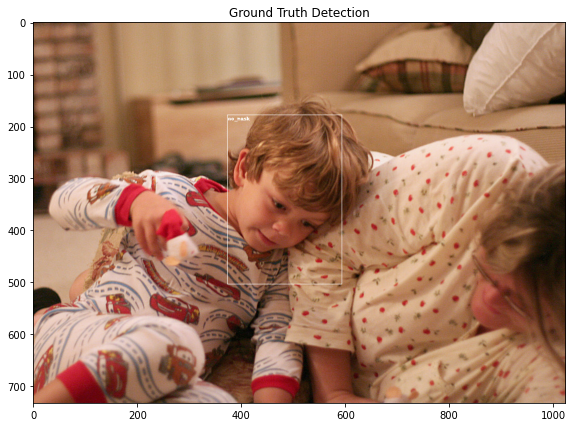

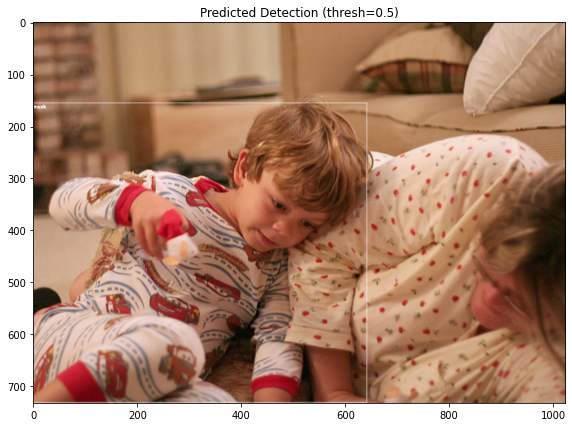

In [ ]:
# Parameters
img_id = 27
th = 0.5  # threshold for confidence score of predicted bboxes to show

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get image sample
img = PIL.Image.open(os.path.join(val_img_dir,val_dataset.coco.loadImgs([img_id])[0]['file_name']))
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = val_dataset.coco.loadAnns(val_dataset.coco.getAnnIds([img_id]))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLO' in model_name:
    pred = model([img])
  else:    
    pred = model([img_torchvision])

# Get label names
label_ids = val_dataset.coco.getCatIds()
label_info = val_dataset.coco.loadCats(label_ids)
label_names = [label['name'] for label in label_info]
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

# Get ground truth bboxes
true_bboxes = convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
true_labels = [labels[obj['category_id']] for obj in img_anns]
true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels)
plt.figure(figsize = (25,7))
plt.title('Ground Truth Detection')
plot = plt.imshow(F.to_pil_image(true_img))

# Get ground truth segmentation masks
# print(img_anns)
# true_masks = F.Tensor([obj['segmentation'][0] for obj in img_anns])
# true_labels = [labels[obj['category_id']] for obj in img_anns]
# true_img = U.draw_segmentation_masks(img, true_masks, true_labels)
# plt.figure(figsize = (25,7))
# plt.imshow(F.to_pil_image(true_img))

# Get predicted bboxes
# For YOLO models
if 'YOLO' in model_name:  
  pred_bboxes = []
  pred_labels = []
  for img in pred.xyxy:
    for bbox in img:
      if bbox[4] > th:  # Show only bboxes with high confidence score
        pred_bboxes.append(bbox[:4])
        pred_labels.append(labels[labels_inv[label_names[int(bbox[5])]]])  # Convert YOLO label to COCO label
  pred_bboxes = torch.stack(pred_bboxes)
# For torchvision models
else:
  pred_bboxes = torch.stack([pred[0]['boxes'][i] for i in range(0,len(pred[0]['boxes'])) if pred[0]['scores'][i] > th])  # Show only bboxes with high confidence score
  pred_labels_ids = torch.stack([pred[0]['labels'][i] for i in range(0,len(pred[0]['labels'])) if pred[0]['scores'][i] > th]).tolist()
  pred_labels = [labels[label_id] for label_id in pred_labels_ids]
pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels)
plt.figure(figsize = (25,7))
plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))